In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import grad as torch_grad

import numpy as np
import matplotlib.pyplot as plt

CTX_SIZE = 10
BLUE_CENTER = (7, 7)
RED_CENTER = (-3, -3)

def gen_2d_guass_dist(mean, size=64):
    cov = [[0.5, 0.], [0., 0.5]]
    pts = np.random.multivariate_normal(mean, cov, size=size)
    return pts

def draw_data(blues, reds):
    plt.plot(BLUE_CENTER[0], BLUE_CENTER[1],
             "*", color="b", linewidth=1,
             markersize=12, label="blue center")
    plt.plot(RED_CENTER[0], RED_CENTER[1],
             "*", color="r", linewidth=1,
              markersize=12, label="red center")
    if blues is not None:
        plt.plot(blues[:, 0], blues[:, 1],
                 '.', alpha=0.12, color="b",
                 label="blue data")
    if reds is not None:
        plt.plot(reds[:, 0], reds[:, 1],
                 '.', alpha=0.12, color="r",
                 label="red data")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid()
    plt.show()

def draw_generated(dist):
    plt.plot(BLUE_CENTER[0], BLUE_CENTER[1],
             "*", color="b", linewidth=1,
             markersize=12, label="blue center")
    plt.plot(RED_CENTER[0], RED_CENTER[1],
             "*", color="r", linewidth=1,
              markersize=12, label="red center")
    if dist is not None:
        plt.plot(dist[:, 0], dist[:, 1],
                 '.', alpha=0.8, color="orange",
                 label="generated")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis("equal")
    plt.grid()
    plt.show()

class FullyConnect(nn.Module):
    def __init__(self, in_size,
                       out_size,
                       activation=None):
        super().__init__()
        self.act = activation
        self.linear = nn.Linear(in_size, out_size)

    def forward(self, x):
        x = self.linear(x)
        if not self.act is None:
            x = self.act(x)
        return x

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_dim = 128
        self.body = nn.Sequential(
            FullyConnect(CTX_SIZE, self.model_dim, nn.ReLU(True)),
            FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True)),
            FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True))
        )
        self.head = nn.Sequential(
            FullyConnect(self.model_dim, 2)
        )

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, use_sigmoid=True, weak_body=True):
        super().__init__()
        self.model_dim = 128
        if weak_body:
            self.body = nn.Sequential(
                FullyConnect(2, self.model_dim, nn.ReLU(True))
            )
        else:
            self.body = nn.Sequential(
                FullyConnect(2, self.model_dim, nn.ReLU(True)),
                FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True)),
                FullyConnect(self.model_dim, self.model_dim, nn.ReLU(True))
            )
        self.head = nn.Sequential(
            FullyConnect(self.model_dim, 1)
        )
        self.use_sigmoid = use_sigmoid

    def forward(self, x):
        x = self.body(x)
        x = self.head(x)
        if self.use_sigmoid:
            x = torch.sigmoid(x)
        return x

    @torch.no_grad()
    def clip(self, bound=0.01):
        for param in self.parameters():
            param.data.clamp_(-bound, bound)

class LossTracer:
    def __init__(self, buf_size=500):
        self.buf_size = buf_size
        self.d_loss_buf = list()
        self.g_loss_buf = list()

    def add_d_loss(self, loss):
        self.d_loss_buf.append(loss)
        while len(self.d_loss_buf) > self.buf_size:
            self.d_loss_buf.pop(0)

    def add_g_loss(self, loss):
        self.g_loss_buf.append(loss)
        while len(self.g_loss_buf) > self.buf_size:
            self.g_loss_buf.pop(0)

    def get_d_loss(self):
        return sum(self.d_loss_buf) / len(self.d_loss_buf)

    def get_g_loss(self):
        return sum(self.g_loss_buf) / len(self.g_loss_buf)

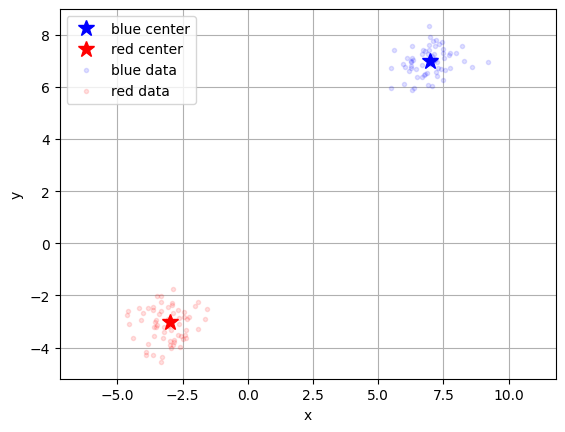

steps: 1000 -> G loss: 0.480347, D loss 1.10573
steps: 2000 -> G loss: 0.479784, D loss 1.10522
steps: 3000 -> G loss: 0.479552, D loss 1.10352
steps: 4000 -> G loss: 0.479448, D loss 1.10482
steps: 5000 -> G loss: 0.478846, D loss 1.1046


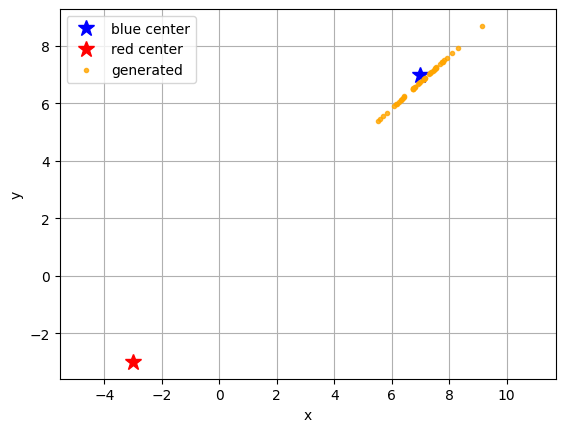

steps: 6000 -> G loss: 0.479123, D loss 1.10174
steps: 7000 -> G loss: 0.478153, D loss 1.10451
steps: 8000 -> G loss: 0.478702, D loss 1.10317
steps: 9000 -> G loss: 0.478743, D loss 1.10296
steps: 10000 -> G loss: 0.479084, D loss 1.10273


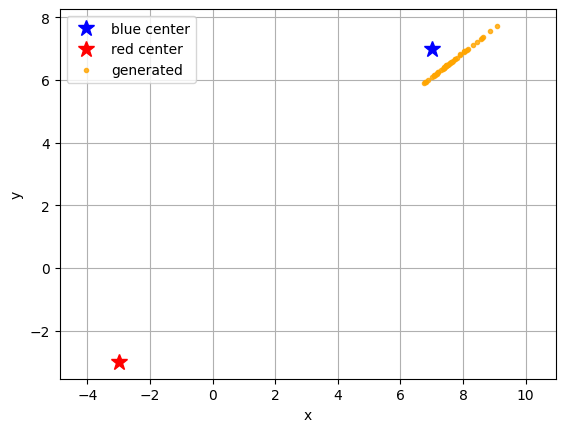

steps: 11000 -> G loss: 0.478905, D loss 1.10067
steps: 12000 -> G loss: 0.47864, D loss 1.10093
steps: 13000 -> G loss: 0.686879, D loss 0.730152
steps: 14000 -> G loss: 0.693523, D loss 0.698236
steps: 15000 -> G loss: 0.692918, D loss 0.697076


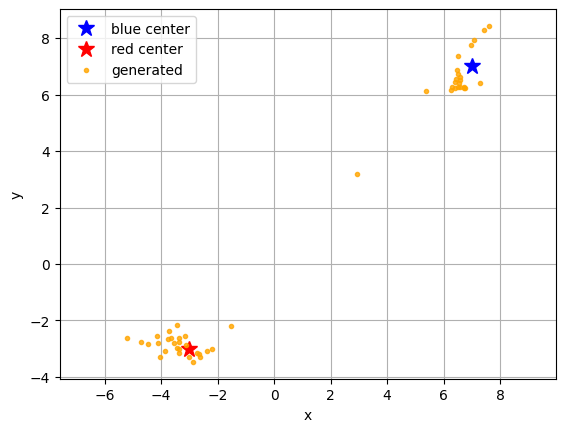

steps: 16000 -> G loss: 0.694688, D loss 0.699932
steps: 17000 -> G loss: 0.693835, D loss 0.69898
steps: 18000 -> G loss: 0.69424, D loss 0.698905
steps: 19000 -> G loss: 0.693839, D loss 0.698169
steps: 20000 -> G loss: 0.693911, D loss 0.699313


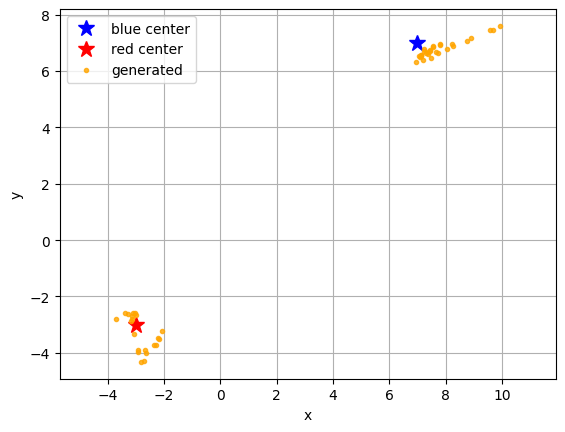

In [2]:
def train_gan():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator()
    loss_fn = nn.BCELoss()
    tracer = LossTracer()

    g_opt = optim.Adam(generator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)
    d_opt = optim.Adam(discriminator.parameters(),
                       lr=0.001,
                       betas=(0.5, 0.999),
                       weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = 20000
    batch_size = len(pairs)

    for s in range(max_steps):
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # train Discriminator
        d_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        real_loss = loss_fn(discriminator(real_data), real_labels)
        fake_loss = loss_fn(discriminator(generator(noise).detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        d_opt.step()
        tracer.add_d_loss(d_loss.item())

        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = loss_fn(discriminator(gen_data), real_labels)
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())
        
        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()
            
train_gan()

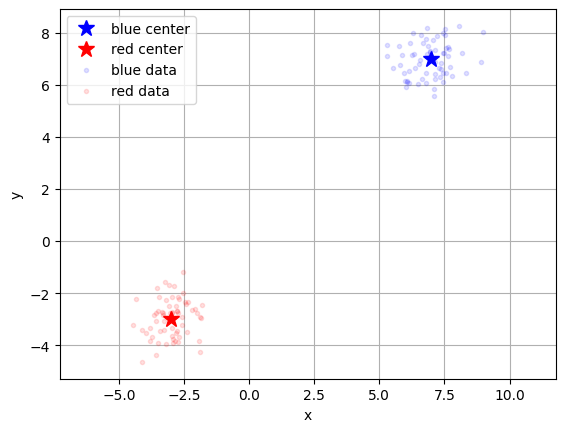

steps: 1000 -> G loss: -0.00517337, D loss -0.00429718
steps: 2000 -> G loss: -0.00175129, D loss -0.0100634
steps: 3000 -> G loss: -0.00142093, D loss -0.0101162
steps: 4000 -> G loss: -0.000831249, D loss -0.011233
steps: 5000 -> G loss: -0.000379736, D loss -0.0111599


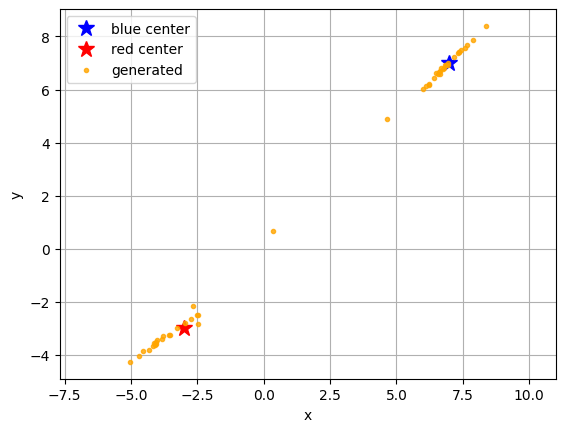

steps: 6000 -> G loss: -0.000285338, D loss -0.012794
steps: 7000 -> G loss: -0.00024394, D loss -0.0137427
steps: 8000 -> G loss: -0.000204096, D loss -0.013769
steps: 9000 -> G loss: -0.000171191, D loss -0.0131672
steps: 10000 -> G loss: -0.00011127, D loss -0.0106068


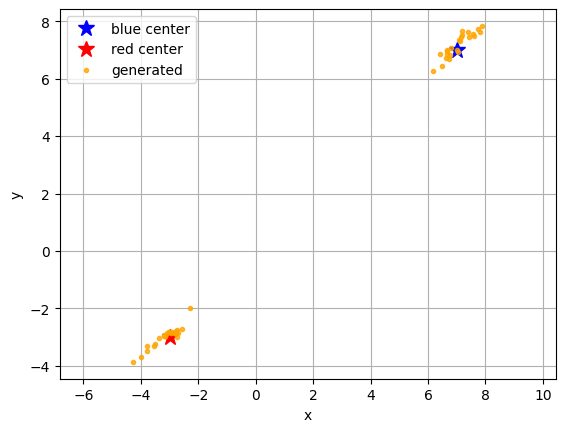

steps: 11000 -> G loss: -7.75289e-05, D loss -0.0119763
steps: 12000 -> G loss: -7.82171e-05, D loss -0.0104604
steps: 13000 -> G loss: -9.92828e-05, D loss -0.0105827
steps: 14000 -> G loss: -8.67811e-05, D loss -0.0119441
steps: 15000 -> G loss: -9.25485e-05, D loss -0.0115612


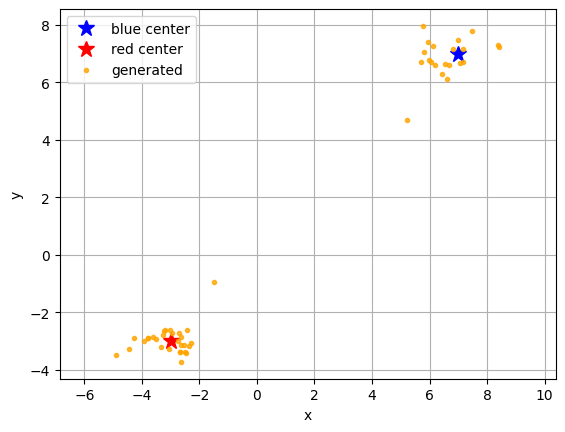

steps: 16000 -> G loss: -0.000104431, D loss -0.00956098
steps: 17000 -> G loss: -0.000122456, D loss -0.0107824
steps: 18000 -> G loss: -8.09037e-05, D loss -0.0106688
steps: 19000 -> G loss: -3.18208e-05, D loss -0.00680052
steps: 20000 -> G loss: -1.2854e-05, D loss -0.00741971


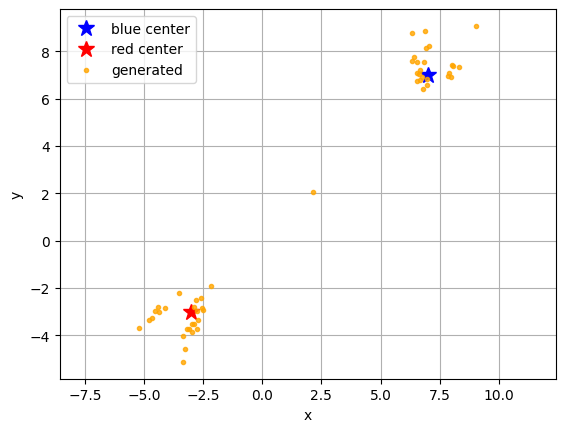

In [3]:
def train_wgan():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator(use_sigmoid=False, weak_body=False)
    discriminator.clip()

    g_opt = optim.RMSprop(generator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)
    d_opt = optim.RMSprop(discriminator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = 20000
    batch_size = len(pairs)
    tracer = LossTracer()

    for s in range(max_steps):
        # train Discriminator
        for _ in range(5):
            d_opt.zero_grad()
            noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
            pred_real_loss = discriminator(real_data)
            pred_real_loss = pred_real_loss.mean()
            pred_fake_loss = discriminator(generator(noise).detach())
            pred_fake_loss = pred_fake_loss.mean()
            d_loss = pred_fake_loss - pred_real_loss
            d_loss.backward()
            d_opt.step()
            discriminator.clip()
            tracer.add_d_loss(d_loss.item())
        
        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = discriminator(gen_data)
        g_loss = -g_loss.mean()
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())

        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()

train_wgan()

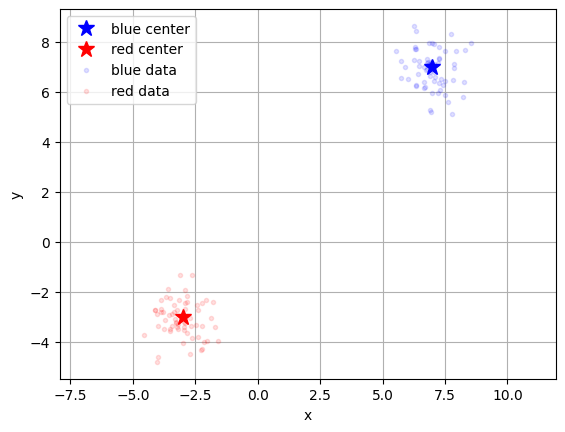

steps: 1000 -> G loss: -10.2664, D loss 4.66781
steps: 2000 -> G loss: -5.12904, D loss 23.6739
steps: 3000 -> G loss: -3.07885, D loss 20.9515
steps: 4000 -> G loss: -1.26246, D loss 17.8693
steps: 5000 -> G loss: -0.620065, D loss 15.4543


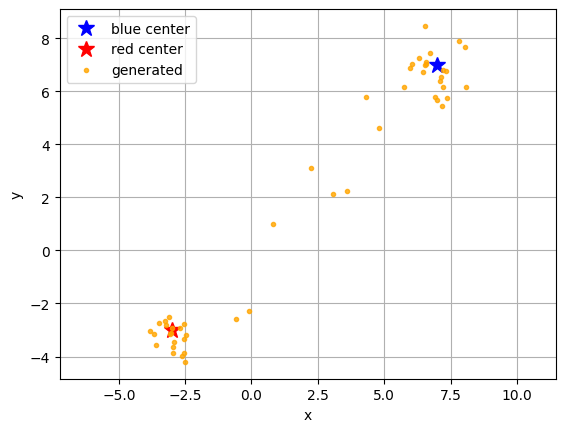

steps: 6000 -> G loss: -0.301729, D loss 11.9525
steps: 7000 -> G loss: -0.243977, D loss 9.91971
steps: 8000 -> G loss: -0.219893, D loss 10.9397
steps: 9000 -> G loss: -0.206547, D loss 9.83372
steps: 10000 -> G loss: -0.185968, D loss 8.53024


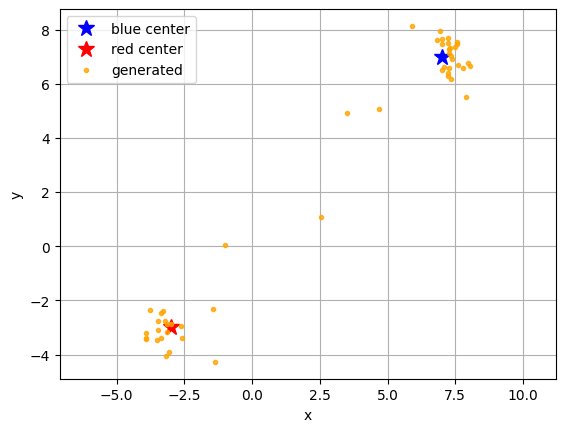

steps: 11000 -> G loss: -0.177364, D loss 7.37916
steps: 12000 -> G loss: -0.156497, D loss 6.88588
steps: 13000 -> G loss: -0.141122, D loss 6.03391
steps: 14000 -> G loss: -0.140467, D loss 6.03903
steps: 15000 -> G loss: -0.133024, D loss 5.69801


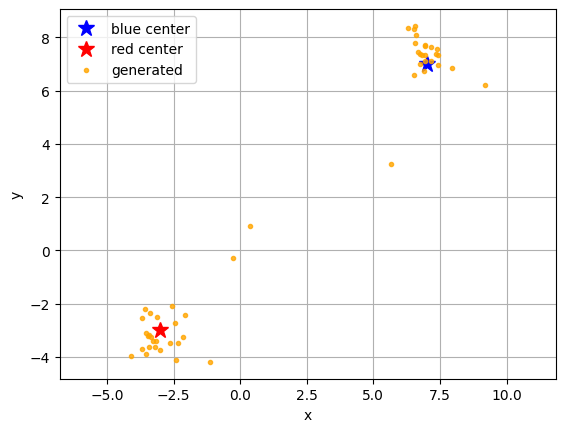

steps: 16000 -> G loss: -0.124511, D loss 5.52553
steps: 17000 -> G loss: -0.122237, D loss 5.13635
steps: 18000 -> G loss: -0.10746, D loss 5.28199
steps: 19000 -> G loss: -0.0978029, D loss 5.30981
steps: 20000 -> G loss: -0.0991517, D loss 5.17839


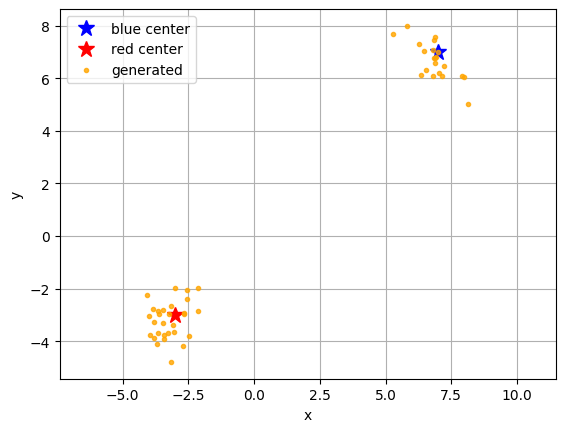

In [4]:
def compute_gradient_penalty(discriminator, real_data, generated_data):
    batch_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand_as(real_data)
    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = Variable(interpolated, requires_grad=True)

    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(batch_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty

def train_wgan_gp():
    blues = gen_2d_guass_dist(BLUE_CENTER)
    reds = gen_2d_guass_dist(RED_CENTER)
    draw_data(blues, reds)
    pairs = np.concatenate((blues, reds), axis=0)

    generator = Generator()
    discriminator = Discriminator(use_sigmoid=False, weak_body=False)

    g_opt = optim.RMSprop(generator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)
    d_opt = optim.RMSprop(discriminator.parameters(),
                          lr=0.00005,
                          weight_decay=0.)

    real_data = torch.from_numpy(np.array(pairs)).float()
    max_steps = 20000
    batch_size = len(pairs)
    tracer = LossTracer()

    for s in range(max_steps):
        # train Discriminator
        for _ in range(5):
            d_opt.zero_grad()
            noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
            gen_data = generator(noise).detach()
            pred_real_loss = discriminator(real_data)
            pred_real_loss = pred_real_loss.mean()
            pred_fake_loss = discriminator(gen_data)
            pred_fake_loss = pred_fake_loss.mean()
            d_loss = pred_fake_loss - pred_real_loss + compute_gradient_penalty(discriminator, real_data, gen_data)
            d_loss.backward()
            d_opt.step()
            tracer.add_d_loss(d_loss.item())
        
        # train Generator
        g_opt.zero_grad()
        noise = torch.normal(0, 1, size=(batch_size, CTX_SIZE))
        gen_data = generator(noise)
        g_loss = discriminator(gen_data)
        g_loss = -g_loss.mean()
        g_loss.backward()
        g_opt.step()
        tracer.add_g_loss(g_loss.item())

        if (s+1) % 1000 == 0:
            print("steps: {} -> G loss: {:.6}, D loss {:.6}".format(
                      s+1, tracer.get_d_loss(), tracer.get_g_loss()))

        if (s+1) % 5000 == 0:
            noise = torch.normal(0, 1, size=(50, CTX_SIZE))
            generator.eval()
            with torch.no_grad():
                draw_generated(generator(noise).detach().cpu().numpy())
            generator.train()

train_wgan_gp()